# Regression using Deep Neural Networks

## Load Dataset from sklearn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df["Target"] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1] = scaler.transform(df.values[:,:-1])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


## Train Model with PyTorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([506, 14])

In [9]:
y = data[:,-1:]
x = data[:,:-1]
print(x.shape, y.shape)

torch.Size([506, 13]) torch.Size([506, 1])


In [10]:
n_epochs = 100000
learning_rate = 1e-4
print_interval = 5000

## Build Models

### Build Model using nn.Module

In [11]:
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(0.1)

In [12]:
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, output_dim)
        self.act = nn.ReLU()
        
    def forward(self, x):
        # |x| = (batch_size, input_dim)
        h = self.act(self.linear1(x)) # |h| = (batch_size, 3)
        h = self.act(self.linear2(h))
        y = self.linear3(h)
        # |y| = (batch_size, output_dim)
        
        return y
    
model = MyModel(x.size(-1), y.size(-1))

model

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)

### Build Model with LeakyReLU using nn.Sequential

In [13]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=3, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=3, out_features=1, bias=True)
)

In [14]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [15]:
for i in range(n_epochs):
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    if (i + 1) % print_interval ==0:
        print('Epoch %d: loss=%.4e' % (i + 1, loss))

Epoch 5000: loss=1.2625e+01
Epoch 10000: loss=1.0925e+01
Epoch 15000: loss=1.0551e+01
Epoch 20000: loss=1.0483e+01
Epoch 25000: loss=1.0322e+01
Epoch 30000: loss=1.0270e+01
Epoch 35000: loss=1.0215e+01
Epoch 40000: loss=1.0193e+01
Epoch 45000: loss=1.0186e+01
Epoch 50000: loss=1.0183e+01
Epoch 55000: loss=1.0181e+01
Epoch 60000: loss=1.0181e+01
Epoch 65000: loss=1.0180e+01
Epoch 70000: loss=1.0176e+01
Epoch 75000: loss=1.0175e+01
Epoch 80000: loss=1.0175e+01
Epoch 85000: loss=1.0175e+01
Epoch 90000: loss=1.0175e+01
Epoch 95000: loss=1.0175e+01
Epoch 100000: loss=1.0174e+01


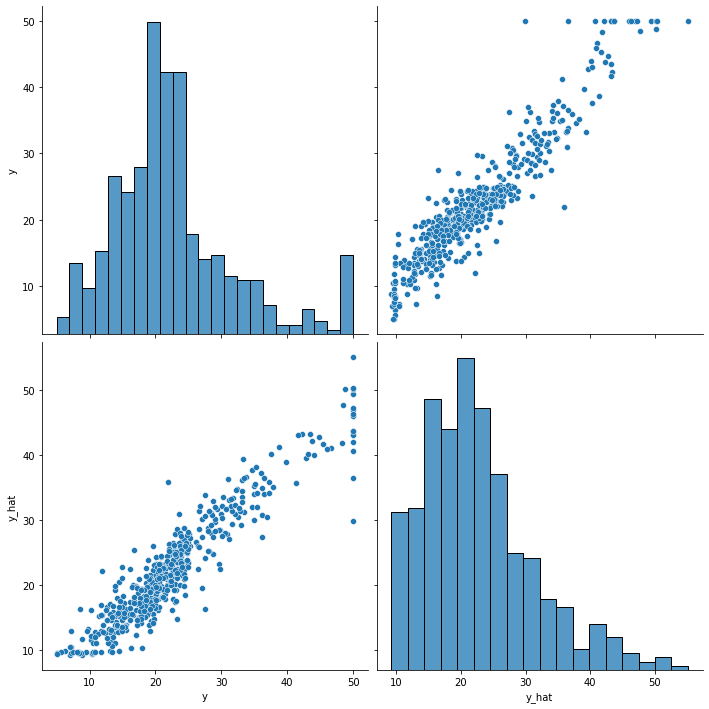

In [16]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()